**Importing libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

**Loading dataset**

In [2]:
df=pd.read_excel('sifarisler.xlsx')
df.head()

,sifarisci,tarix,Satis (azn)
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sifarisci    1990 non-null   object        
 1   tarix        1999 non-null   datetime64[ns]
 2   Satis (azn)  1990 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.0+ KB


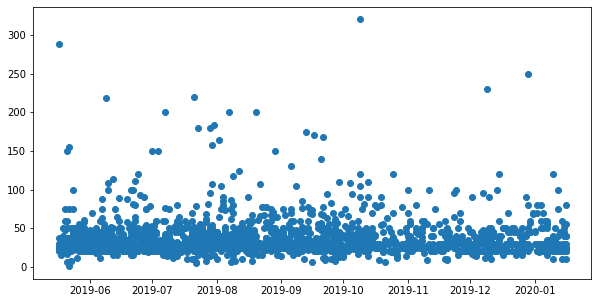

In [4]:
plt.figure(figsize=(10,5))
plt.scatter(df['tarix'],df['Satis (azn)'])
plt.show()

According to the figure above, we see sale transactions generally were in zero(0), 65 azn interval

In [5]:
df.rename(columns={'sifarisci':'id','Satis (azn)':'satis'},inplace=True)
df.head()

,id,tarix,satis
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      1981 non-null   object        
 1   tarix   1981 non-null   datetime64[ns]
 2   satis   1981 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 61.9+ KB


In [7]:
df.id.nunique() # looking number of unique customers

1546

In [8]:
cst=pd.DataFrame(df['id'].unique(),columns=['uid']).astype('str')
cst

,uid
0,556227575
1,557660657
2,556724772
3,505244006
4,546450050
...,...
1541,556402456
1542,555552227
1543,552007006
1544,552264462


**On recency**

In [9]:
df_rcn=df.groupby('id')['tarix'].max().reset_index()
df_rcn['recency']=(df_rcn['tarix'].max() - df_rcn['tarix']).dt.days
df_rcn.drop(columns=['tarix'], inplace=True)
df_rcn

,id,recency
0,224,167
1,45002262,200
2,50407770,219
3,54272224,188
4,55252426,188
...,...,...
1541,0776262626,44
1542,0776262726,217
1543,0777656656,205
1544,Emin,240


**On frequency**

In [10]:
df_frq=df.groupby('id')['tarix'].count().reset_index()
df_frq['frequency']=df_frq['tarix']
df_frq.drop(columns=['tarix'], inplace=True)
df_frq

,id,frequency
0,224,2
1,45002262,1
2,50407770,1
3,54272224,1
4,55252426,1
...,...,...
1541,0776262626,1
1542,0776262726,1
1543,0777656656,1
1544,Emin,1


**On Monetary**

Usually, Monetary is accepted as the sum of all purchase(or other types of) values, but in this case, due to my goal, it was considered and calculated as average

In [11]:
# on average sale(revenue) for each customer
df_rvn=df.groupby('id')['satis'].mean().reset_index()
df_rvn.rename(columns={'satis':'mean_rev'}, inplace=True)
df_rvn

,id,mean_rev
0,224,86.0
1,45002262,36.0
2,50407770,30.0
3,54272224,14.0
4,55252426,30.0
...,...,...
1541,0776262626,40.0
1542,0776262726,30.0
1543,0777656656,28.0
1544,Emin,6.0


In [12]:
# Merging datasets to RFM 
rfm=df_rcn.merge(df_frq, left_on='id', right_on='id').merge(df_rvn, left_on='id', right_on='id')
rfm.head()

,id,recency,frequency,mean_rev
0,224,167,2,86.0
1,45002262,200,1,36.0
2,50407770,219,1,30.0
3,54272224,188,1,14.0
4,55252426,188,1,30.0


**Data Normalization(Scaling)**

In [13]:
# Scaling
md_rfm=rfm[['recency','frequency','mean_rev']]
rb=RobustScaler()
rb.fit(md_rfm)
md_rfm=pd.DataFrame(rb.transform(md_rfm), columns=['recency','frequency','mean_rev'])
md_rfm['id']=rfm.id
md_rfm.head()

,recency,frequency,mean_rev,id
0,0.188119,1.0,3.500,224
1,0.514851,0.0,0.375,45002262
2,0.702970,0.0,0.000,50407770
3,0.396040,0.0,-1.000,54272224
4,0.396040,0.0,0.000,55252426


I aim to divide customers into **four** segmentation: **Loyal customers, Can't lose them, Lost customers, New customers**

**Modelling**

In [14]:
kms=KMeans(n_clusters=4)
kms.fit(md_rfm[['recency','frequency','mean_rev']])
clustered=pd.DataFrame(kms.predict(md_rfm[['recency','frequency','mean_rev']]), columns=['Segmented_group'])
clustered=clustered.merge(md_rfm, left_index=True, right_index=True)
clustered

,Segmented_group,recency,frequency,mean_rev,id
0,0,0.188119,1.0,3.500,224
1,2,0.514851,0.0,0.375,45002262
2,2,0.702970,0.0,0.000,50407770
3,2,0.396040,0.0,-1.000,54272224
4,2,0.396040,0.0,0.000,55252426
...,...,...,...,...,...
1541,0,-1.029703,0.0,0.625,0776262626
1542,2,0.683168,0.0,0.000,0776262726
1543,2,0.564356,0.0,-0.125,0777656656
1544,2,0.910891,0.0,-1.500,Emin


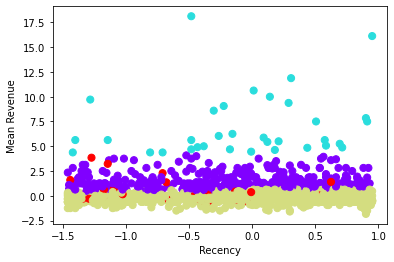

In [15]:
plt.scatter(clustered['recency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Recency')
plt.ylabel('Mean Revenue')
plt.show()

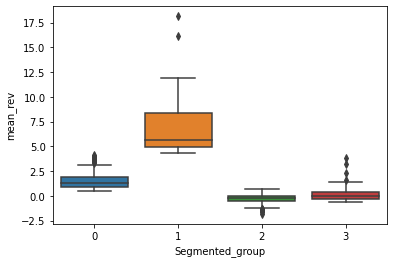

In [16]:
sns.boxplot('Segmented_group', 'mean_rev',data=clustered)
plt.show()

Can be seen, 2-nd segmentation is a too wealthy group of customers, therefore **"Can't lose them"**

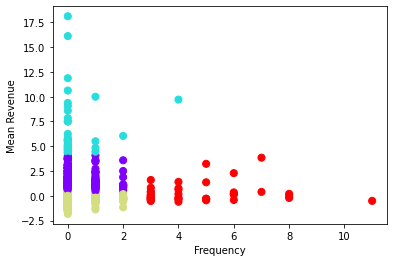

In [17]:
plt.scatter(clustered['frequency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Frequency')
plt.ylabel('Mean Revenue')
plt.show()

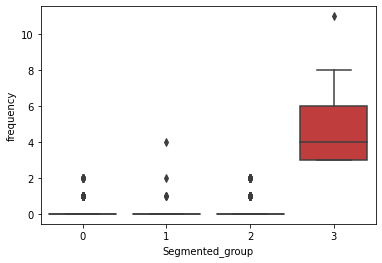

In [18]:
sns.boxplot('Segmented_group', 'frequency',data=clustered)
plt.show()

3-rd segmentation holds those customers who most frequently do purchase, so that is **"Loyal Customers"**

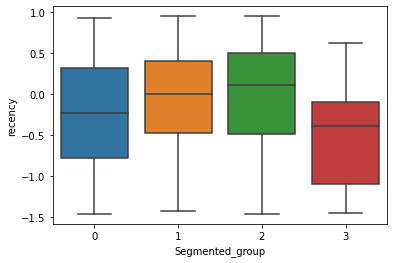

In [19]:
sns.boxplot('Segmented_group', 'recency',data=clustered)
plt.show()
#sns.boxenplot('Segmented_group','recency',data=clustured)

Less period means they purchases recently, hence 0 segmentation are **"New Customers"** and other(1) segmentation displays, **"Lost Customers"**, unfortunately

### 3- Loyal customers, 2- Can't lose them, 1- Lost customers, 0- New customers

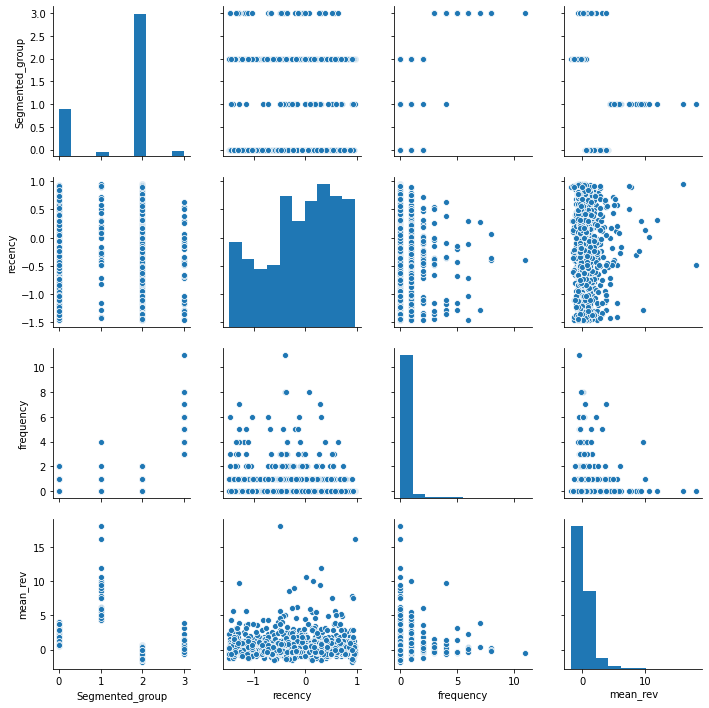

In [20]:
sns.pairplot(clustered)
plt.show()